## MBL Temp (GFS) - SST (NOAA)

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import datetime

**Date for figures**

In [ ]:
#date = '20230411_00z'
#date = '20230402_00z'
#date = '20230322_00z'

#---Oaxaca
#date = '20230219_00z'
date = '20230222_00z'

**SST for 20230411_00z**
* labeled as "preliminary"

In [ ]:
#fname_sst = "/Volumes/Turner2/FalseLowClouds/Analysis/Model/Gulf_Stream/20230411/oisst-avhrr-v02r01.20230411_preliminary.nc"
#fname_sst = "/Volumes/Turner2/FalseLowClouds/Analysis/Model/Gulf_Stream/20230402/oisst-avhrr-v02r01.20230402_preliminary.nc"
#fname_sst = "/Volumes/Turner2/FalseLowClouds/Analysis/Model/Gulf_Stream/20230322/oisst-avhrr-v02r01.20230322.nc"

#---Oaxaca
#fname_sst = "/Volumes/Turner2/FalseLowClouds/Analysis/Model/Oaxaca/20230219/oisst-avhrr-v02r01.20230219.nc"
fname_sst = "/Volumes/Turner2/FalseLowClouds/Analysis/Model/Oaxaca/20230222/oisst-avhrr-v02r01.20230222.nc"


ds_sst = xr.open_dataset(fname_sst)
ds_sst =  ds_sst.squeeze()
ds_sst

In [ ]:
#fname_mbl = "/Volumes/Turner2/FalseLowClouds/Analysis/Model/Gulf_Stream/20230411/gfs.t00z.pgrb2.0p25.f000"
#fname_mbl = "/Volumes/Turner2/FalseLowClouds/Analysis/Model/Gulf_Stream/20230402/gfs.t00z.pgrb2.0p25.f000"
#fname_mbl = "/Volumes/Turner2/FalseLowClouds/Analysis/Model/Gulf_Stream/20230322/gfs.t00z.pgrb2.0p25.f000"

#---Oaxaca
fname_mbl = "/Volumes/Turner2/FalseLowClouds/Analysis/Model/Oaxaca/20230222/gfs.t00z.pgrb2.0p25.f000"

ds_mbl = xr.open_dataset(fname_mbl, engine="cfgrib",backend_kwargs={'filter_by_keys': {'typeOfLevel':'isobaricInhPa'}})
ds_mbl

Gulf Stream Coordinates

In [ ]:
# min_lon = -83 + 360
# min_lat = 50
# max_lon = -51 + 360
# max_lat = 26

Oaxaca Coordinates

In [ ]:
min_lon = -110 + 360
min_lat = 21.8
max_lon = -87.7 + 360
max_lat = 9.42

In [ ]:
min_press = 850 #mb
max_press = 1000 #mb

In [ ]:
cropped_ds_sst = ds_sst.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon))
cropped_ds_sst.sst.values = cropped_ds_sst.sst.values+273.15

In [ ]:
cropped_ds_mbl = ds_mbl.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon,max_lon))

cropped_ds_mbl = cropped_ds_mbl.sel(isobaricInhPa=slice(max_press,min_press))

mean_ds_mbl = cropped_ds_mbl.mean(dim='isobaricInhPa')

mean_ds_mbl = mean_ds_mbl.squeeze()
mean_ds_mbl = mean_ds_mbl.reindex(latitude=mean_ds_mbl.latitude[::-1])

In [ ]:
max_ds_mbl = cropped_ds_mbl.max(dim='isobaricInhPa')

max_ds_mbl = max_ds_mbl.squeeze()
max_ds_mbl = max_ds_mbl.reindex(latitude=max_ds_mbl.latitude[::-1])

In [ ]:
#Trims off the extra lat and lon point on the MBL data

begin = cropped_ds_sst.sst.shape[0]
end = cropped_ds_sst.sst.shape[1]

diff = mean_ds_mbl.t[0:begin,0:end].values - cropped_ds_sst.sst[:,:].values

In [ ]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.PiYG_r

ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS)
c=ax.contourf(cropped_ds_sst.lon, cropped_ds_sst.lat, cropped_ds_sst.sst, cmap=cmap)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('SST ('+ date+')')
clb.set_label('Temperature (K)')

In [ ]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.RdYlBu_r

ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS)
c=ax.contourf(cropped_ds_sst.lon, cropped_ds_sst.lat, diff, cmap=cmap)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Averaged MBL Temp - SST ('+date+')')
clb.set_label('Temperature (K)')

**Normalizing the temperature difference**
* Set normalization range to [bottom limit,2]
* Pegging a bottom limit for temperature difference

In [ ]:
bottom_lim = -4

diff_np = np.asarray(diff).copy()
under_zero = diff_np < bottom_lim
diff_np[under_zero] = bottom_lim

In [ ]:
top_T = 4

diff_norm = diff_np/(top_T - bottom_lim)

**Normalizing the specific humidity**

In [ ]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Greens

ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS)
c=ax.contourf(max_ds_mbl.longitude, max_ds_mbl.latitude, max_ds_mbl.q, cmap=cmap)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Specific Humidity (Max in MBL) ('+date+')')
clb.set_label('kg kg$^{-1}$')

In [ ]:
top_q = 0.016
bottom_q = 0.000
q_norm = (max_ds_mbl.q[0:begin,0:end].values)/(top_q - bottom_q)
q_norm_av = (mean_ds_mbl.q[0:begin,0:end].values)/(top_q - bottom_q)

**Finding the FLC index**
* normalized temperature difference times normalized relative humidity

In [ ]:
flc_index = diff_norm*q_norm

In [ ]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
#cmap.set_over('maroon')
levels = np.linspace(-0.5, 0.5, 21)

ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS)
c=ax.contourf(cropped_ds_sst.lon, cropped_ds_sst.lat, flc_index, cmap=cmap, levels=levels, extend='both')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('FLC Index (T diff > '+str(bottom_lim)+') ('+date+')')
clb.set_label('%')

## Time Lapse FLC

**Loading and prepping data**

Allows me to delete the large grib file in favor of two smaller pickle files

In [ ]:
root = "/Volumes/Turner2/FalseLowClouds/Analysis/Model/Time_Lapse/"

date = '20230323'

In [ ]:
gfs_file = root+date+"/gfs.t00z.pgrb2.0p25.f000"

gfs_ds = xr.open_dataset(gfs_file, engine="cfgrib",backend_kwargs={'filter_by_keys': {'typeOfLevel':'isobaricInhPa'}})

Mean and max for the GFS to the marine boundary layer:

In [ ]:
min_press = 850 #mb
max_press = 1000 #mb

gfs_ds = gfs_ds.sel(isobaricInhPa=slice(max_press,min_press))

gfs_ds_mean = gfs_ds.mean(dim='isobaricInhPa')
gfs_ds_mean = gfs_ds_mean.squeeze()
gfs_ds_mean = gfs_ds_mean.reindex(latitude=gfs_ds_mean.latitude[::-1])

gfs_ds_max = gfs_ds.max(dim='isobaricInhPa')
gfs_ds_max = gfs_ds_max.squeeze()
gfs_ds_max = gfs_ds_max.reindex(latitude=gfs_ds_max.latitude[::-1])

Creating and saving the T-diff:

In [ ]:
t = gfs_ds_mean.t

t.to_netcdf(root+date+'/t_'+date+'.nc')

Saving the moisture:
* currently using max in layer

In [ ]:
q = gfs_ds_max.q

q.to_netcdf(root+date+'/q_'+date+'.nc')

**Loading pre-made data**

In [ ]:
root = "/Volumes/Turner2/FalseLowClouds/Analysis/Model/Time_Lapse/"

date = '20230324'

sst_file = root+date+"/oisst-avhrr-v02r01."+date+".nc"

sst_ds = xr.open_dataset(sst_file)
sst_ds =  sst_ds.squeeze()
sst_ds.sst.values = sst_ds.sst.values+273.15

In [ ]:
t = xr.open_dataset(root+date+'/t_'+date+'.nc')
q = xr.open_dataset(root+date+'/q_'+date+'.nc')

In [ ]:
min_lon = -83 + 360
min_lat = 50
max_lon = -51 + 360
max_lat = 26

In [ ]:
sst_ds = sst_ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon))
t = t.sel(latitude=slice(max_lat,min_lat), longitude=slice(min_lon,max_lon))
q = q.sel(latitude=slice(max_lat,min_lat), longitude=slice(min_lon,max_lon))

In [ ]:
begin = sst_ds.sst.shape[0]
end = sst_ds.sst.shape[1]

dims = t.t[0:begin,0:end]

diff = t.t[0:begin,0:end].values - sst_ds.sst[:,:].values

In [ ]:
bottom_lim = -4

diff_np = np.asarray(diff).copy()
under_zero = diff_np < bottom_lim
diff_np[under_zero] = bottom_lim

In [ ]:
top_T = 4

diff_norm = diff_np/(top_T - bottom_lim)

In [ ]:
top_q = 0.016
bottom_q = 0.000
q_norm = (q.q[0:begin,0:end].values)/(top_q - bottom_q)
q_norm_av = (q.q[0:begin,0:end].values)/(top_q - bottom_q)

In [ ]:
flc_index = diff_norm*q_norm

In [ ]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(-0.5, 0.5, 21)

ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS)
c=ax.contourf(dims.longitude, dims.latitude, flc_index, cmap=cmap, levels=levels, extend='both')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('FLC Index (T diff > '+str(bottom_lim)+') ('+date+')')
clb.set_label('%')

**Bulk loading pre-made data**

In [2]:
def FLC_warn_xarray(date):
    
    sst_file = root+date+"/oisst-avhrr-v02r01."+date+".nc"
    sst_ds = xr.open_dataset(sst_file)
    sst_ds =  sst_ds.squeeze()
    sst_ds.sst.values = sst_ds.sst.values+273.15
    
    t = xr.open_dataset(root+date+'/t_'+date+'.nc')
    q = xr.open_dataset(root+date+'/q_'+date+'.nc')
    
    min_lon = -83 + 360
    min_lat = 50
    max_lon = -51 + 360
    max_lat = 26

    sst_ds = sst_ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon))
    t = t.sel(latitude=slice(max_lat,min_lat), longitude=slice(min_lon,max_lon))
    q = q.sel(latitude=slice(max_lat,min_lat), longitude=slice(min_lon,max_lon))

    begin = sst_ds.sst.shape[0]
    end = sst_ds.sst.shape[1]

    dims = t.t[0:begin,0:end]

    diff = t.t[0:begin,0:end].values - sst_ds.sst[:,:].values

    bottom_lim = -4

    diff_np = np.asarray(diff).copy()
    under_zero = diff_np < bottom_lim
    diff_np[under_zero] = bottom_lim

    top_T = 4

    diff_norm = diff_np/(top_T - bottom_lim)

    top_q = 0.016
    bottom_q = 0.000
    q_norm = (q.q[0:begin,0:end].values)/(top_q - bottom_q)
    q_norm_av = (q.q[0:begin,0:end].values)/(top_q - bottom_q)

    flc_index = diff_norm*q_norm

    #---Building the xarray dataset
    
    row_meshgrid, col_meshgrid = np.meshgrid(dims.latitude, dims.longitude, indexing='ij')

    ds = xr.Dataset(
        data_vars=dict(
            flc_index=(["x","y"], flc_index)
        ),
        coords=dict(
            latitude=(["x","y"], row_meshgrid),
            longitude=(["x","y"], col_meshgrid),
        ),
        attrs=dict(description="FLC index in the US Atlantic region"),
    )
    
    ds = ds.expand_dims(dim={"time": 1})
    
    return ds

Add the datetimes in here: 

In [3]:
root = "/Volumes/Turner2/FalseLowClouds/Analysis/Model/Time_Lapse/"

FLC_3d_xarray = [FLC_warn_xarray('20230322'), FLC_warn_xarray('20230323'), 
                       FLC_warn_xarray('20230324'), FLC_warn_xarray('20230325')]

dates = [datetime.datetime(2023, 3, 22), datetime.datetime(2023, 3, 23), datetime.datetime(2023, 3, 24),
        datetime.datetime(2023, 3, 25)]

In [4]:
da_concat = xr.concat(FLC_3d_xarray, pd.Index(dates, name='time'))

In [5]:
tot = da_concat.sum(dim='time')

In [6]:
flc_above = tot.flc_index.where(tot.flc_index > 0.1)

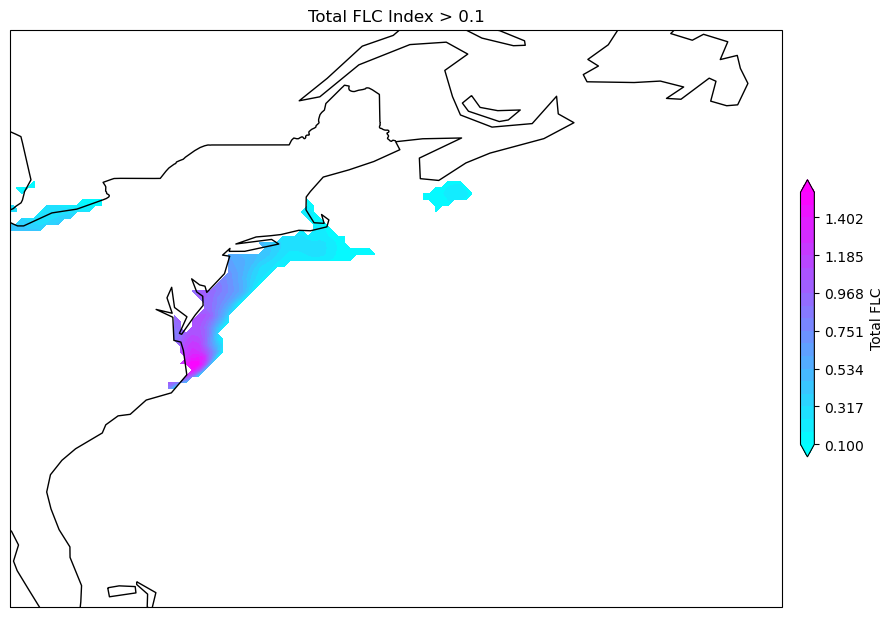

In [7]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.cool
levels = np.linspace(0.1, np.amax(flc_above), 21)

ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS)
c=ax.contourf(flc_above.longitude[0,:], flc_above.latitude[:,0], flc_above, cmap=cmap, levels=levels, extend='both')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Total FLC Index > 0.1')
clb.set_label('Total FLC')

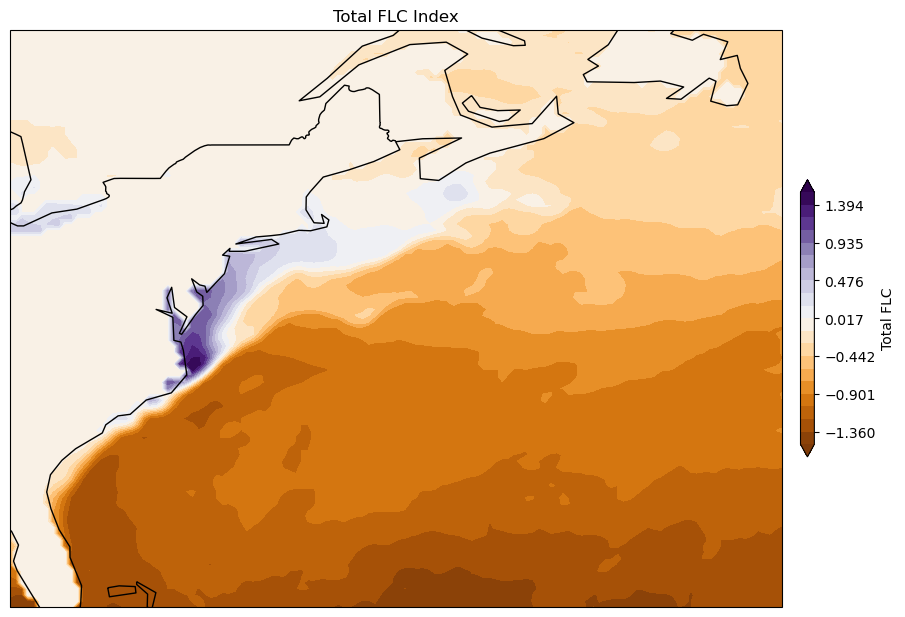

In [8]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.PuOr
levels = np.linspace(np.amin(tot.flc_index), np.amax(tot.flc_index), 21)

ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS)
c=ax.contourf(tot.longitude[0,:], tot.latitude[:,0], tot.flc_index, cmap=cmap, levels=levels, extend='both')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Total FLC Index')
clb.set_label('Total FLC')

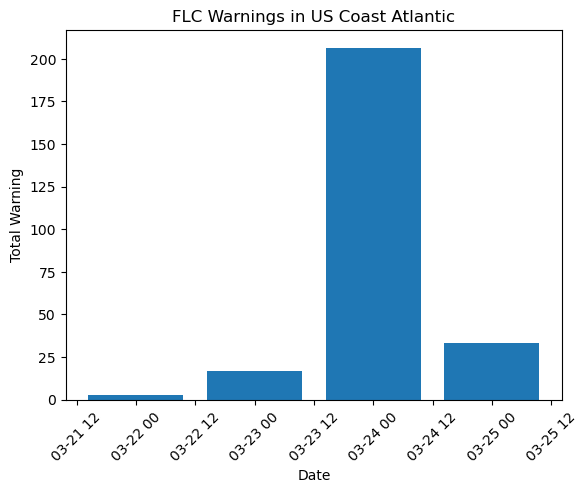

In [9]:
flc_above = []
da_tot_area = []
flc_above = da_concat.flc_index.where(da_concat.flc_index > 0.1)
da_tot_area = flc_above.sum(dim='x').sum(dim='y')

plt.bar(da_tot_area['time'], da_tot_area)

# add labels and title
plt.xlabel('Date')
plt.ylabel('Total Warning')
plt.title('FLC Warnings in US Coast Atlantic')
plt.xticks(rotation=45)

# display the plot
plt.show()